In [1]:
# !curl -L -o ../data/chest-xray-pneumonia.zip https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia

# !unzip ../data/chest-xray-pneumonia.zip -d ../data/
!rm -R ../data/chest_xray//chest_xray/

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('dark'))

## Load and Visualize data:


In [3]:
trainImages = tf.keras.utils.image_dataset_from_directory('../data/chest_xray/train')
trainImages.cardinality().numpy() * 32

Found 5216 files belonging to 2 classes.


5216

In [4]:
#load dataset from cell in tfrecord format:
trainImages = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
trainPaths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)



traindataset = tf.data.Dataset.zip((trainImages , trainPaths))

2025-09-30 10:14:28.237642: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-09-30 10:14:28.276338: W external/local_xla/xla/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Could not resolve hostname', error details: Could not resolve host: metadata.google.internal".


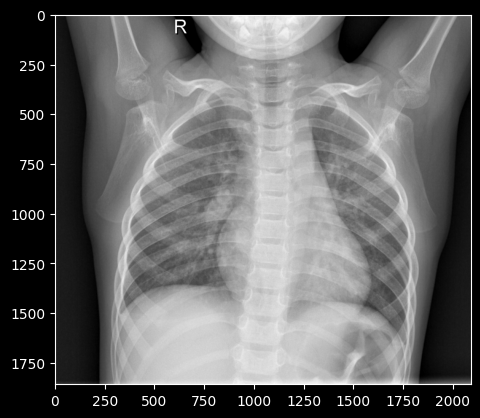

In [5]:
raw_img , raw_label = next(iter(traindataset))
rimage = tf.image.decode_jpeg(raw_img , channels = 3)
# plt.imshow(tf.image.resize(rimage , (224 , 224))/225)
plt.imshow(rimage/255)

In [6]:
#craete (image , label) pair, the ones you get by default from tf.keras.utils.image_dataset_from_directory()

# for x , y in traindataset.take(1):
#     print(y.numpy().decode('utf-8'))

def get_label(filepath):
    parts = tf.strings.split(filepath , '/')
    return parts[-2] == 'PNEUMONIA'

def decode_image(image):
    image = tf.image.decode_jpeg(image , channels = 3)
    return tf.image.resize(image , (224 , 224))

def processdata(image , filepath):
    label = get_label(filepath)
    image = decode_image(image)
    return (image , label)

traindataset = traindataset.map(processdata , num_parallel_calls= tf.data.AUTOTUNE)

In [7]:
cnormal = len([path for path in trainPaths if 'NORMAL' in path.numpy().decode('utf-8')])
cabnormal = len([path for path in trainPaths if 'PNEUMONIA' in path.numpy().decode('utf-8')])

print(f"Normal Images: {cnormal} , Pneumonia Images: {cabnormal} , total images in training set: {cnormal + cabnormal}")

2025-09-30 10:14:48.656884: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Normal Images: 1349 , Pneumonia Images: 3883 , total images in training set: 5232


2025-09-30 10:14:50.533276: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# 0 -> normal
# 1 -> pneumonia
ctotal = cnormal + cabnormal
w0 = (ctotal / (2 * cnormal))
w1 = (ctotal / (2 * cabnormal))
w0 , w1

(1.939214232765011, 0.6737058975019315)

In [32]:
#same thing for testdata:
testImages = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
testpaths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)

testdataset = tf.data.Dataset.zip((testImages , testpaths))
testdataset = testdataset.map(processdata , num_parallel_calls= tf.data.AUTOTUNE)

In [28]:
#tuning for better training:
traindataset = traindataset.shuffle(traindataset.cardinality()).batch(32 * 8)

2025-09-30 10:20:56.537407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:71: Filling up shuffle buffer (this may take a while): 1 of -2
2025-09-30 10:21:06.673013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:71: Filling up shuffle buffer (this may take a while): 119 of -2
2025-09-30 10:21:16.810677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:71: Filling up shuffle buffer (this may take a while): 236 of -2
2025-09-30 10:21:36.837248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:71: Filling up shuffle buffer (this may take a while): 455 of -2
2025-09-30 10:21:47.314377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:71: Filling up shuffle buffer (this may take a while): 567 of -2
2025-09-30 10:21:59.024099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:71: Filling up shuffle buffer (this may take a while): 681 

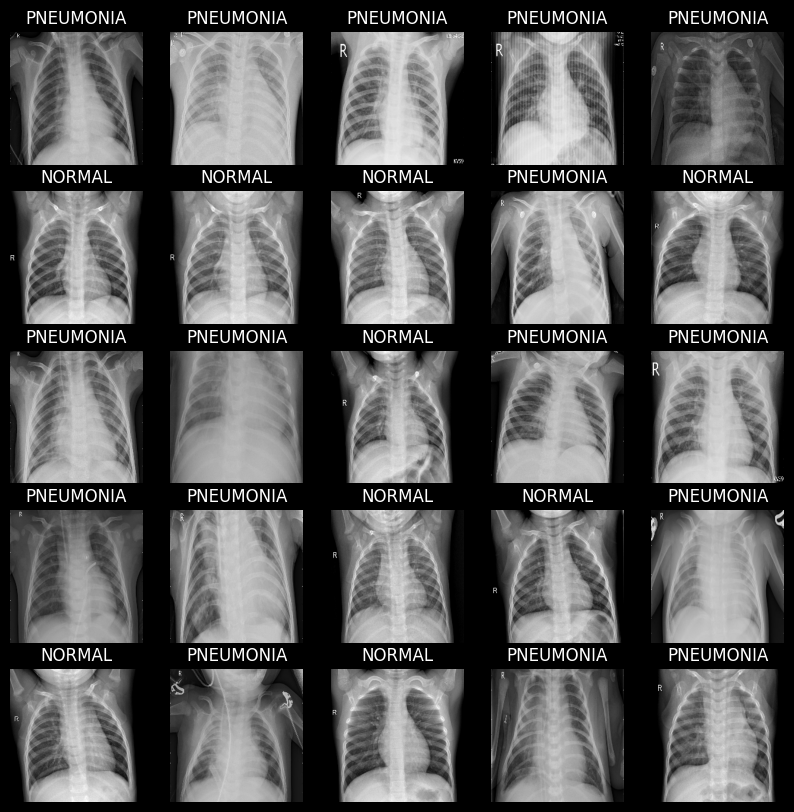

In [29]:
#visualize traindataset:
def show_batch(ibatch , lbatch):
    plt.figure(figsize = (10 , 10))
    for i in range(25):
        plt.subplot(5 , 5, i + 1)
        plt.imshow(ibatch[i] / 255)
        plt.axis('off')
        if lbatch[i]:plt.title('PNEUMONIA')
        else: plt.title('NORMAL')

ibatch , lbatch = next(iter(traindataset))
show_batch(ibatch.numpy() , lbatch.numpy())

In [ ]:
ds = tf.data.Dataset.range(10)
ds = ds.shuffle(ds.cardinality()).batch(4)
for x in ds:
    print(x)
ds.cardinality()

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


<tf.Tensor: shape=(), dtype=int64, numpy=10>

<bound method DatasetV2.batch of <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.bool, name=None))>>